In [1]:
import pandas as pd
import pandas.io.sql as pdsql
from pandas import DataFrame
import numpy as np
import scipy as sp
from numpy import NaN, Inf, arange, isscalar, asarray, array

import mysql.connector

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.font_manager as font_manager
import seaborn as sns

#맑은고딕체
sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.0)
matplotlib.rcParams['figure.figsize'] = [12, 8]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=10)

In [2]:
def comma_volume(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}K'.format(int(x/1000))
    return s

def comma_price(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s

def comma_percent(x, pos):  # formatter function takes tick label and tick position
    s = '{:+.2f}'.format(x)
    return s

major_date_formatter = dates.DateFormatter('%Y-%m')
minor_date_formatter = dates.DateFormatter('%m')
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)

In [3]:
class NumpyMySQLConverter(mysql.connector.conversion.MySQLConverter):
    """ A mysql.connector Converter that handles Numpy types """

    def _float32_to_mysql(self, value):
        return float(value)

    def _float64_to_mysql(self, value):
        return float(value)

    def _int32_to_mysql(self, value):
        return int(value)

    def _int64_to_mysql(self, value):
        return int(value)

    def _timestamp_to_mysql(self, value):
        return value.to_datetime()

데이타베이스_설정값 = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'PASSWORD',
    'database': 'DB_NAME',
    'raise_on_warnings': True,
}

MySQL_POOL_SIZE = 2

def mysqlconn():
    conn = mysql.connector.connect(pool_name="pool_name", pool_size=MySQL_POOL_SIZE, **데이타베이스_설정값)
    conn.set_converter_class(NumpyMySQLConverter)
    return conn

In [4]:
# 지정한 종목 및 기간의 추천리스트를 읽어온다. 
def get_stock_recommend(code, 시작일자, 종료일자):
    if 시작일자 == None and 종료일자 == None:
        query = """
            select 일자, 종목코드, 종목명, 추천일가격, 추천증권사, 의견, 목표가, 추천사유
            from 증권사추천주
            where 종목코드='%s'
            order by 일자 asc
        """ % (code)
    if 시작일자 != None and 종료일자 == None:
        query = """
            select 일자, 종목코드, 종목명, 추천일가격, 추천증권사,  의견, 목표가, 추천사유
            from 증권사추천주
            where 종목코드='%s' AND 일자 >= '%s'
            order by 일자 asc
        """ % (code, 시작일자)
    if 시작일자 == None and 종료일자 != None:
        query = """
            select 일자, 종목코드, 종목명, 추천일가격, 추천증권사,  의견, 목표가, 추천사유
            from 증권사추천주
            where 종목코드='%s' AND 일자 <= '%s'
            order by 일자 asc
        """ % (code, 종료일자)
    if 시작일자 != None and 종료일자 != None:
        query = """
            select 일자, 종목코드, 종목명, 추천일가격, 추천증권사,  의견, 목표가, 추천사유
            from 증권사추천주
            where 종목코드='%s' AND 일자 BETWEEN '%s' AND '%s'
            order by 일자 asc
        """ % (code, 시작일자, 종료일자)
    
    conn = mysqlconn()
    df = pdsql.read_sql_query(query, con=conn)
    conn.close()
    
    df.fillna(0, inplace=True)
    df.set_index('일자', inplace=True)
    return df
    
# 지정한 일자의 모든 추천리스트를 읽어온다.    
def get_stock_recommend_list(시작일자, 종료일자):
    if 시작일자 == None and 종료일자 == None:
        query = """
            select 일자, 종목코드, 종목명, 의견, 목표가, 추천일가격, 추천증권사, 추천사유 from 증권사추천주 
            order by 종목코드, 일자 asc
        """
    if 시작일자 != None and 종료일자 == None:
        query = """
            select 일자, 종목코드, 종목명, 의견, 목표가, 추천일가격, 추천증권사, 추천사유 from 증권사추천주 
            where 일자 >= '%s'
            order by 종목코드, 일자 asc
        """ % (시작일자)
    if 시작일자 == None and 종료일자 != None:
        query = """
            select 일자, 종목코드, 종목명, 의견, 목표가, 추천일가격, 추천증권사, 추천사유 from 증권사추천주 
            where 일자 <= '%s'
            order by 종목코드, 일자 asc
        """ % (종료일자)
    if 시작일자 != None and 종료일자 != None:
        query = """
            select 일자, 종목코드, 종목명, 의견, 목표가, 추천일가격, 추천증권사, 추천사유 from 증권사추천주 
            where 일자 BETWEEN '%s' AND '%s'
            order by 종목코드, 일자 asc
        """ % (시작일자, 종료일자)

    conn = mysqlconn()
    df = pdsql.read_sql_query(query, con=conn)
    conn.close()
    
    df.fillna(0, inplace=True)
    df.set_index('일자', inplace=True)
    return df    

def GetCode(name):
    conn = mysqlconn()
    query = """
            select 종목코드
            from 종목코드
            where 종목명 = '%s'
        """ % name

    df = pdsql.read_sql_query(query, con=conn)
    # print(df['종목명'][0])
    conn.close()
    return df['종목코드'][0]

def get_price(code, 시작일자=None, 종료일자=None):
    if 시작일자 == None and 종료일자 == None:
        query = """
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량
        FROM 일별주가
        WHERE 종목코드='%s'
        ORDER BY 일자 ASC
        """ % (code)
    if 시작일자 != None and 종료일자 == None:
        query = """
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량
        FROM 일별주가
        WHERE 종목코드='%s' AND 일자 >= '%s'
        ORDER BY 일자 ASC
        """ % (code, 시작일자)
    if 시작일자 == None and 종료일자 != None:
        query = """
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량
        FROM 일별주가
        WHERE 종목코드='%s' AND 일자 <= '%s'
        ORDER BY 일자 ASC
        """ % (code, 종료일자)
    if 시작일자 != None and 종료일자 != None:
        query = """
        SELECT 일자, 시가, 고가, 저가, 종가, 거래량
        FROM 일별주가
        WHERE 종목코드='%s' AND 일자 BETWEEN '%s' AND '%s'
        ORDER BY 일자 ASC
        """ % (code, 시작일자, 종료일자)

    conn = mysqlconn()
    df = pdsql.read_sql_query(query, con=conn)    
    conn.close()
    
    df.set_index('일자', inplace=True)
    
    return df

# 기간 내 추천주 리스트 확인

In [5]:
# 2020년 1월부터 9월까지 추천종목 리스트를 구한다.
df_list = get_stock_recommend_list(시작일자='2020-01-01', 종료일자='2020-09-22')

# 2020년 8월 부터의 추천리스트를 선정한다.
ndf_list = df_list['2020-08':]
ndf_list.head()

,종목코드,종목명,의견,목표가,추천일가격,추천증권사,추천사유
일자,,,,,,,
2020-08-12,000060,메리츠화재,BUY,19000,13050,KB증권강승건 외2,-2Q20 Review: 장기보험 합산비율 개선을 통해 이익 증가 메리츠화재에 대...
2020-08-12,000060,메리츠화재,,0,13050,메리츠증권 김고은,"-2Q20 실적 Review 2Q20 당기순이익 1,058억원(-1.7 QoQ, ..."
2020-08-13,000060,메리츠화재,BUY,18000,13050,삼성증권 장효선,-2Q review - 사업비율 개선으로 양호한 실적 기록 보험영업지표 전부문 양...
2020-08-13,000060,메리츠화재,HOLD,15000,13050,DB금융투자 이병건,"-질병담보 손해율, 크게 오른 것으로 추정 매각이익 실현 규모 확대로 예상치 상회..."
2020-08-13,000060,메리츠화재,HOLD,14500,13050,NH투자증권 정준섭,-2분기 비교적 양호한 실적 달성 하반기 위험손해율 방향이 관건


In [6]:
# 종목코드, 종목명, 추천일 가격별로 추천수를 구한다.
ndf_group = ndf_list.groupby(['종목코드','종목명','추천일가격'])
group_count = ndf_group.count()

# 삼성전자 증권사추천 확인 및 주가 그래프 연동

In [7]:
종목명 = '삼성전자'
종목 = GetCode(종목명)

시작일자 = '2020-01-01'
종료일자 = '2020-09-22'

# 종목의 주가정보를 읽어온다
df = get_price(종목, 시작일자, 종료일자)

# 종목의 증권사추천 리스트를 읽어온다
df_recommend = get_stock_recommend(종목, 시작일자, 종료일자)

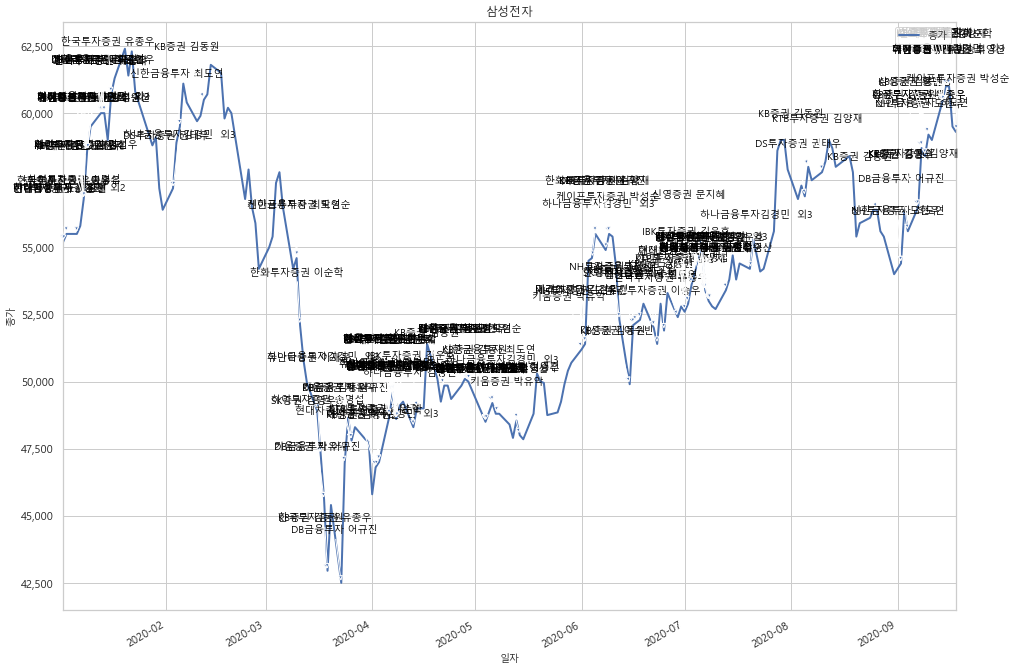

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(16,12), sharex=True)

ax1 = df[['종가']].plot(ax=ax1, sharex=True, linewidth=2, title = 종목명)
ax1.xaxis.set_major_formatter(major_date_formatter)
ax1.yaxis.set_major_formatter(price_formatter)
ax1.set_xlabel('일자', fontproperties=fp)
ax1.set_ylabel('종가', fontproperties=fp)
ax1.legend(loc="best", prop=fp)

for idx, row in df_recommend.iterrows():
    종목코드, 종목명, 추천일가격, 추천증권사, 의견, 목표가, 추천사유 = row
    try:
        ax1.annotate(추천증권사, xy=(idx, df['종가'][idx]), xytext=(-50, 50), textcoords='offset points',
            color='black', arrowprops=dict(arrowstyle='-|>'), fontproperties=fp)
    except Exception as e:
        pass
    
plt.show()

In [ ]:
df_recommend = df_recommend.query("추천증권사=='유진투자증권 이상우'")

fig, ax1 = plt.subplots(1, 1, figsize=(16,12), sharex=True)

ax1 = df[['종가']].plot(ax=ax1, sharex=True, linewidth=2, title = 종목명)
ax1.yaxis.set_major_formatter(price_formatter)
ax1.set_xlabel('일자', fontproperties=fp)
ax1.set_ylabel('종가', fontproperties=fp)
ax1.legend(loc="best", prop=fp)

for idx, row in df_recommend.iterrows():
    종목코드, 종목명, 추천일가격, 추천증권사, 의견, 목표가, 추천사유 = row
    try:
        ax1.annotate("%s(%s)" % (추천증권사, 목표가), xy=(idx, df['종가'][idx]), xytext=(-50, 50), textcoords='offset points',
            color='black', arrowprops=dict(arrowstyle='-|>'), fontproperties=fp)
    except Exception as e:
        pass
    
plt.show()